# Proyek Analisis Data: E-Commerce Public Dataset
- **Nama:** Ni Luh Putu Happy Nirmala
- **Email:** m014b4kx3335@bangkit.academy happynirmala010104@gmail.com
- **ID Dicoding:** happy_nirmala

## Menentukan Pertanyaan Bisnis

- Berdasarkan kategorinya, manakah produk yang paling memberikan pendapatan terbanyak?
- Bagaimana tingkat akurat antara tanggal pengiriman yang diperkirakan dan tanggal pengiriman sebenarnya?

## Import Semua Packages/Library yang Digunakan

In [81]:
!pip install folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

## Data Wrangling

### Gathering Data

In [ ]:
# Read CSV files into DataFrames
sellers = pd.read_csv('sellers_dataset.csv')
products = pd.read_csv('products_dataset.csv')
orders_review = pd.read_csv('order_reviews_dataset.csv')
orders = pd.read_csv('orders_dataset.csv')
product_category_translation = pd.read_csv('product_category_name_translation.csv')
order_items = pd.read_csv('order_items_dataset.csv')
order_payments = pd.read_csv('order_payments_dataset.csv')
geolocation = pd.read_csv('geolocation_dataset.csv')
customers = pd.read_csv('customers_dataset.csv')

In [ ]:
# Merge Datasets for Question 1
# Merge order_items with products
order_items_products = pd.merge(order_items, products, on='product_id', how='left')

# Merge with product category translation
order_items_products = pd.merge(order_items_products, product_category_translation, on='product_category_name', how='left')

# Merge with orders to get order dates
order_items_products = pd.merge(order_items_products, orders[['order_id', 'customer_id']], on='order_id', how='left')

# Merge with customers to get customer location
order_items_products = pd.merge(order_items_products, customers[['customer_id', 'customer_zip_code_prefix']], on='customer_id', how='left')

In [ ]:
# Merge Datasets for Question 2
# Select relevant columns from orders dataset
orders_delivery = orders[['order_id', 'order_estimated_delivery_date', 'order_delivered_customer_date']]

**Insight:**
- Membaca file CSV dataset dari Kaggle yang telah diupload ke session storage
- Merge dataset dengan left join

### Assessing Data

In [ ]:
# Checking for missing values
# For Question 1 dataset
print("Missing values in order_items_products:")
print(order_items_products.isnull().sum())

# For Question 2 dataset
print("\nMissing values in orders_delivery:")
print(orders_delivery.isnull().sum())

Missing values in order_items_products:
order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
product_category_name            1603
product_name_lenght              1603
product_description_lenght       1603
product_photos_qty               1603
product_weight_g                   18
product_length_cm                  18
product_height_cm                  18
product_width_cm                   18
product_category_name_english    1627
customer_id                         0
customer_zip_code_prefix            0
dtype: int64

Missing values in orders_delivery:
order_id                            0
order_estimated_delivery_date       0
order_delivered_customer_date    2965
dtype: int64


In [ ]:
# Check for duplicates
print(f"\nNumber of duplicate rows in order_items_products: {order_items_products.duplicated().sum()}")
print(f"Number of duplicate rows in orders_delivery: {orders_delivery.duplicated().sum()}")


Number of duplicate rows in order_items_products: 0
Number of duplicate rows in orders_delivery: 0


In [ ]:
# Check for negative prices
invalid_prices = order_items_products[order_items_products['price'] < 0]
print(f"Number of products with invalid prices: {len(invalid_prices)}")

# Validate date types
date_columns = ['order_delivered_customer_date', 'order_estimated_delivery_date']
invalid_date_values = pd.DataFrame()

# Convert date columns to datetime and check for invalid entries
for col in date_columns:
    orders_delivery.loc[:, col] = pd.to_datetime(orders_delivery[col], errors='coerce')
    invalid_rows = orders_delivery[orders_delivery[col].isna()]

    if not invalid_rows.empty:
        invalid_rows_copy = invalid_rows.copy()
        invalid_rows_copy['invalid_column'] = col

        invalid_date_values = pd.concat([invalid_date_values, invalid_rows_copy], ignore_index=True)

print("\nInvalid date values:")
print(invalid_date_values)

Number of products with invalid prices: 0

Invalid date values:
                              order_id order_estimated_delivery_date  \
0     136cce7faa42fdb2cefd53fdc79a6098                    2017-05-09   
1     ee64d42b8cf066f35eac1cf57de1aa85                    2018-06-28   
2     0760a852e4e9d89eb77bf631eaaf1c84                    2018-08-21   
3     15bed8e2fec7fdbadb186b57c46c92f2                    2017-10-03   
4     6942b8da583c2f9957e990d028607019                    2018-02-07   
...                                ...                           ...   
2960  3a3cddda5a7c27851bd96c3313412840                    2018-10-01   
2961  e9e64a17afa9653aacf2616d94c005b8                    2018-02-06   
2962  a89abace0dcc01eeb267a9660b5ac126                    2018-09-27   
2963  a69ba794cc7deb415c3e15a0a3877e69                    2017-09-15   
2964  5fabc81b6322c8443648e1b21a6fef21                    2017-10-23   

     order_delivered_customer_date  delivery_accuracy  \
0             

In [ ]:
# Checking for outliers in 'price'
Q1 = order_items_products['price'].quantile(0.25)
Q3 = order_items_products['price'].quantile(0.75)
IQR = Q3 - Q1

outliers = order_items_products[(order_items_products['price'] < (Q1 - 1.5 * IQR)) | (order_items_products['price'] > (Q3 + 1.5 * IQR))]
print(f"Number of outliers in 'price': {len(outliers)}")

Number of outliers in 'price': 4004


**Insight:**
- Check missing value
- Check duplikasi data
- Check invalid data: untuk dataset 1 dicek harga yang kurang dari 0 dan untuk dataset 2 dicek tipe data tanggalnya
- Check outlier di price dengan IQR method

### Cleaning Data

In [ ]:
# Handling missing values in order_items_products
print("\nOrder Items Products before handling missing values:")
print(order_items_products.head())

# Filling missing categorical values with 'Unknown'
order_items_products['product_category_name'] = order_items_products['product_category_name'].fillna('Unknown')
order_items_products['product_category_name_english'] = order_items_products['product_category_name_english'].fillna('Unknown')

# List of numeric columns with missing values
numerical_columns = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                     'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

# Filling missing values for numeric columns using linear interpolation
order_items_products[numerical_columns] = order_items_products[numerical_columns].interpolate(method='linear')

print("\nOrder Items Products after handling missing values:")
print(order_items_products.head())

# Handling missing values in orders_delivery
print("\nOrders Delivery before handling missing values:")
print(orders_delivery.head())
orders_delivery_copy = orders_delivery.copy()

# Converting date columns to datetime
orders_delivery_copy['order_delivered_customer_date'] = pd.to_datetime(orders_delivery_copy['order_delivered_customer_date'], errors='coerce')
orders_delivery_copy['order_estimated_delivery_date'] = pd.to_datetime(orders_delivery_copy['order_estimated_delivery_date'], errors='coerce')

# Interpolating missing date values
orders_delivery_copy['order_delivered_customer_date'] = orders_delivery_copy['order_delivered_customer_date'].astype('int64') // 10**9
orders_delivery_copy['order_estimated_delivery_date'] = orders_delivery_copy['order_estimated_delivery_date'].astype('int64') // 10**9

# Interpolating on the copied DataFrame
orders_delivery_copy['order_delivered_customer_date'] = orders_delivery_copy['order_delivered_customer_date'].interpolate(method='linear')
orders_delivery_copy['order_estimated_delivery_date'] = orders_delivery_copy['order_estimated_delivery_date'].interpolate(method='linear')

# Converting back to datetime
orders_delivery_copy['order_delivered_customer_date'] = pd.to_datetime(orders_delivery_copy['order_delivered_customer_date'], unit='s', errors='coerce')
orders_delivery_copy['order_estimated_delivery_date'] = pd.to_datetime(orders_delivery_copy['order_estimated_delivery_date'], unit='s', errors='coerce')

print("\nOrders Delivery after handling missing values:")
print(orders_delivery_copy.head())


Order Items Products before handling missing values:
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   
2  000229ec398224ef6ca0657da4fc703e              1   
3  00024acbcdf0a6daa1e931b038114c75              1   
4  00042b26cf59d7ce69dfabb4e55b4fd9              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   
2  c777355d18b72b67abbeef9df44fd0fd  5b51032eddd242adc84c38acab88f23d   
3  7634da152a4610f1595efa32f14722fc  9d7a1d34a5052409006425275ba1c2b4   
4  ac6c3623068f30de03045865e4e10089  df560393f3a51e74553ab94004ba5c87   

   shipping_limit_date   price  freight_value product_category_name  \
0  2017-09-19 09:45:35   58.90          13.29            cool_stuff   
1  2017-05-03 11:05:13  239.90          

In [ ]:
# Remove duplicate rows from order_items_products
order_items_products.drop_duplicates(inplace=True)
orders_delivery_copy = orders_delivery.copy()
orders_delivery_copy.drop_duplicates(inplace=True)
orders_delivery = orders_delivery_copy

# Print the results to verify duplicates were removed
print(f"Number of rows in order_items_products after dropping duplicates: {order_items_products.shape[0]}")
print(f"Number of rows in orders_delivery after dropping duplicates: {orders_delivery.shape[0]}")

Number of rows in order_items_products after dropping duplicates: 112650
Number of rows in orders_delivery after dropping duplicates: 99441


In [ ]:
# Check the data types of specified columns in orders_delivery
print("Data types in orders_delivery:")
print(orders_delivery.dtypes)

# Specifically check the types for the two columns of interest
delivered_date_type = orders_delivery['order_delivered_customer_date'].dtype
estimated_delivery_date_type = orders_delivery['order_estimated_delivery_date'].dtype

# Check if they are datetime64[ns]
if delivered_date_type == 'datetime64[ns]':
    print("\n'order_delivered_customer_date' is of type datetime.")
else:
    print("\n'order_delivered_customer_date' is NOT of type datetime. Current type:", delivered_date_type)

if estimated_delivery_date_type == 'datetime64[ns]':
    print("'order_estimated_delivery_date' is of type datetime.")
else:
    print("'order_estimated_delivery_date' is NOT of type datetime. Current type:", estimated_delivery_date_type)

Data types in orders_delivery:
order_id                                 object
order_estimated_delivery_date    datetime64[ns]
order_delivered_customer_date    datetime64[ns]
delivery_accuracy                       float64
dtype: object

'order_delivered_customer_date' is of type datetime.
'order_estimated_delivery_date' is of type datetime.


In [ ]:
# Imputation of outliers with median
median_price = order_items_products['price'].median()
order_items_products['price'] = np.where(
    (order_items_products['price'] < (Q1 - 1.5 * IQR)) | (order_items_products['price'] > (Q3 + 1.5 * IQR)),
    median_price,
    order_items_products['price']
)

**Insight:**
- Menangani missing value di dataset 1 dibagi menjadi 2 yaitu: untuk data categorical, missing value ditangani dengan metode Imputation dengan cara mengisinya dengan Unknown; dan untuk data numeric, missing value ditangani dengan metode interpolation
- Menangani missing value di dataset 2 dengan metode interpolation
- Removed data duplikasi dengan method drop_duplicates
- Check kembali tipe data tanggal apakah sudah datetime atau belum, karena sudah maka tidak ada mengubah tipe data lagi
- Untuk mengatasi outlier imputation dengan nilai median

## Exploratory Data Analysis (EDA)

### Explore ...

In [ ]:
# Calculate revenue and count of products for each product category
category_revenue = order_items_products.groupby('product_category_name_english')['revenue'].sum().reset_index()
category_count = order_items_products.groupby('product_category_name_english')['order_item_id'].count().reset_index()

# Rename the count column for clarity
category_count.rename(columns={'order_item_id': 'product_count'}, inplace=True)

# Merge revenue and product count data
category_stats = pd.merge(category_revenue, category_count, on='product_category_name_english')

# Sort by revenue for better visualization
category_stats.sort_values(by='revenue', ascending=False, inplace=True)

# Display the category revenue and product count
print("\nTotal revenue and product count by product category:")
print(category_stats)


Total revenue and product count by product category:
   product_category_name_english     revenue  product_count
8                 bed_bath_table  1083615.30          11115
16         computers_accessories   847411.85           7827
44                 health_beauty   801560.63           9670
66                sports_leisure   784461.72           8641
40               furniture_decor   770991.67           8334
..                           ...         ...            ...
36                       flowers     1257.14             33
12             cds_dvds_musicals      820.00             14
47                home_comfort_2      731.37             30
30     fashion_childrens_clothes      569.85              8
62         security_and_services      283.29              2

[72 rows x 3 columns]


In [ ]:
# Calculate delivery accuracy
orders_delivery['delivery_accuracy'] = (
    orders_delivery['order_estimated_delivery_date'] - orders_delivery['order_delivered_customer_date']
).dt.days

**Insight:**
- Mengelompokkan data dengan method groupby

## Visualization & Explanatory Analysis

### Pertanyaan 1:

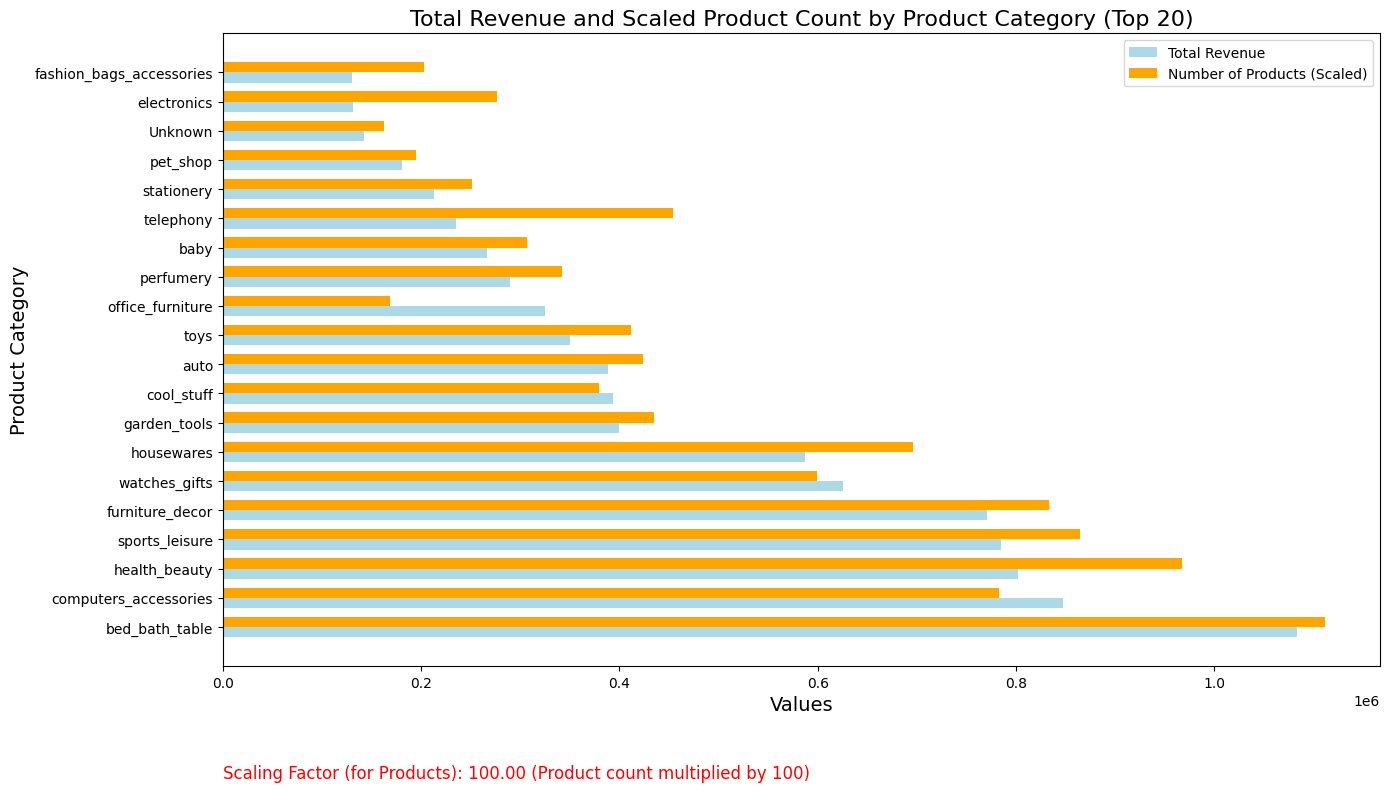

In [ ]:
# Limit to top 20 categories by revenue
top_20_category_stats = category_stats.head(20)

# Set the figure size
plt.figure(figsize=(14, 8))

# Define the bar width
bar_width = 0.35

# Define the positions of bars
positions = range(len(top_20_category_stats))

# Manual scaling factor of 100
scaling_factor = 100
scaled_product_count = top_20_category_stats['product_count'] * scaling_factor

# Create horizontal bars for revenue
plt.barh(positions, top_20_category_stats['revenue'], height=bar_width, label='Total Revenue', color='lightblue')

# Create horizontal bars for scaled product count
plt.barh([p + bar_width for p in positions], scaled_product_count, height=bar_width, label='Number of Products (Scaled)', color='orange')

# Adding titles and labels
plt.title('Total Revenue and Scaled Product Count by Product Category (Top 20)', fontsize=16)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Product Category', fontsize=14)
plt.yticks([p + bar_width / 2 for p in positions], top_20_category_stats['product_category_name_english'])

# Add legend
plt.legend(loc='upper right')

# Add scaling factor information
scaling_text = f"Scaling Factor (for Products): {scaling_factor:.2f} (Product count multiplied by 100)"
plt.text(1, -5, scaling_text, fontsize=12, color='red')

plt.tight_layout()
plt.show()

### Pertanyaan 2:

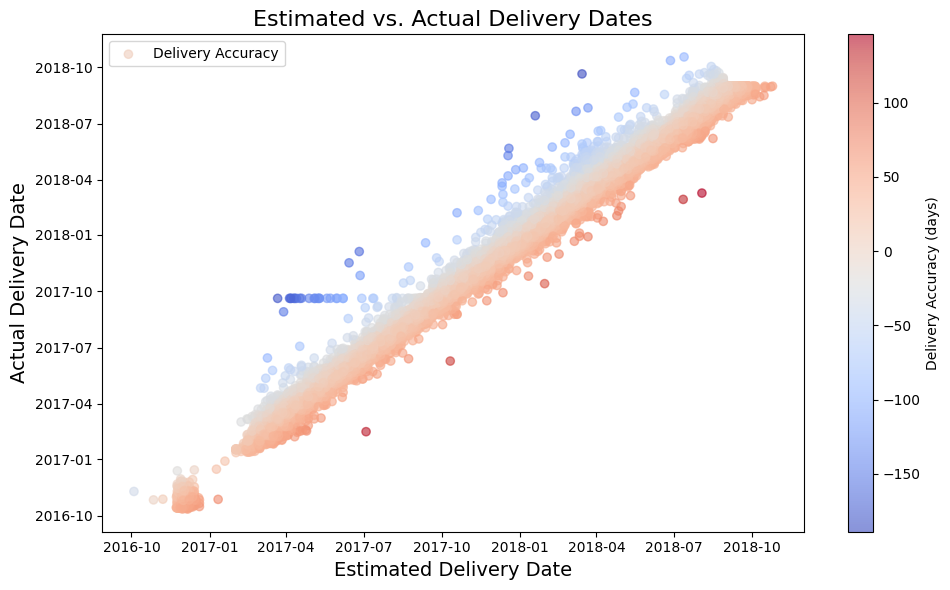

In [ ]:
# Scatter Plot Visualization

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot, showing actual vs estimated delivery dates
plt.scatter(
    orders_delivery['order_estimated_delivery_date'],
    orders_delivery['order_delivered_customer_date'],
    c=orders_delivery['delivery_accuracy'],
    cmap='coolwarm',
    alpha=0.6
)

# Add a color bar to interpret the accuracy
plt.colorbar(label='Delivery Accuracy (days)')

# Adding explanatory details (title, labels, legend)
plt.title('Estimated vs. Actual Delivery Dates', fontsize=16)
plt.xlabel('Estimated Delivery Date', fontsize=14)
plt.ylabel('Actual Delivery Date', fontsize=14)

# Add legend for better understanding of plot
plt.legend(['Delivery Accuracy'], loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

**Insight:**
- Visualisasi data yang paling cocok untuk pertanyaan 1 adalah Clustered Bar Chart karena chart ini dapat menampilkan kategori mana yang memberikan pendapatan paling banyak dengan membandingkan antara total pendapatan dan jumlah produk per kategorinya
- Karena perbandingan antara total pendapatan dan jumlah produk per kategorinya sangat jauh, agar chart lebih mudah dibaca, maka untuk total pendapatan digunakan skala 100 dari total pendapatan sebenarnya
- Visualisasi data yang cocok untuk pertanyaan 2 adalah Scatter Plot karena dapat melihat  hubungan antara dua variabel yaitu tanggal pengiriman yang diperkirakan dan tanggal pengiriman yang sebenarnya sehingga bisa menunjukkan pengiriman yang sangat jauh dari tanggal yang diperkirakan
- Selain itu ditambahkan informasi konteks dalam visualisasi data yang telah dibuat yaitu title, label axes, dan legend

## Analisis Lanjutan (Opsional)

In [78]:
#Geospatial analysis
# Load datasets
sellers = pd.read_csv('sellers_dataset.csv')
customers = pd.read_csv('customers_dataset.csv')
geolocation = pd.read_csv('geolocation_dataset.csv')

# Drop duplicates in geolocation data
geolocation = geolocation.drop_duplicates(subset='geolocation_zip_code_prefix')

# Merge sellers and customers with geolocation data based on zip_code_prefix
sellers_geo = pd.merge(sellers, geolocation, how='left', left_on='seller_zip_code_prefix', right_on='geolocation_zip_code_prefix')
customers_geo = pd.merge(customers, geolocation, how='left', left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix')

# Preview data
sellers_geo.head(), customers_geo.head()


(                          seller_id  seller_zip_code_prefix  \
 0  3442f8959a84dea7ee197c632cb2df15                   13023   
 1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844   
 2  ce3ad9de960102d0677a81f5d0bb7b2d                   20031   
 3  c0f3eea2e14555b6faeea3dd58c1b1c3                    4195   
 4  51a04a8a6bdcb23deccc82b0b80742cf                   12914   
 
          seller_city seller_state  geolocation_zip_code_prefix  \
 0           campinas           SP                      13023.0   
 1         mogi guacu           SP                      13844.0   
 2     rio de janeiro           RJ                      20031.0   
 3          sao paulo           SP                       4195.0   
 4  braganca paulista           SP                      12914.0   
 
    geolocation_lat  geolocation_lng   geolocation_city geolocation_state  
 0       -22.898536       -47.063125           campinas                SP  
 1       -22.382941       -46.946641         mogi-guacu   

In [85]:
# Create a base map centered around Brazil
m = folium.Map(location=[-14.2350, -51.9253], zoom_start=4)

# Create list of latitude and longitude for sellers
sellers_location = sellers_geo[['geolocation_lat', 'geolocation_lng']].dropna()

# Add HeatMap layer for sellers
HeatMap(data=sellers_location, radius=10).add_to(m)

# Display the map 
m

## Conclusion

- Conclution pertanyaan 1
Berdasarkan Clustered Bar Chart, kategori produk yang menghasilkan pendapatan paling banyak adalah "bed_bath_table". Hal ini terlihat dari bar total revenue yang paling panjang dibandingkan dengan kategori produk lainnya, selain itu "bed_bath_table" juga merupakan kategori yang total produknya terjual paling banyak di pasaran.
- Conclution pertanyaan 2
Berdasarkan Scatter Plot, titik biru menandakan pengiriman yang lebih cepat dari perkiraan, sementara titik merah menandakan pengiriman yang terlambat dari perkiraan. Dari hal tersebut terlihat bahwa sebagian besar pengiriman cukup akurat namun ada sejumlah pengiriman yang sangat tidak akurat, yang lebih cepat atau yang terlambat